In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('HSI','2018-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_2176/3609140658.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


Open          High           Low         Close  \
Date                                                                 
2018-01-02  30515.300781  30515.300781  30515.300781  30515.300781   
2018-01-03  30560.900391  30560.900391  30560.900391  30560.900391   
2018-01-04  30736.500000  30736.500000  30736.500000  30736.500000   
2018-01-05  30814.599609  30814.599609  30814.599609  30814.599609   
2018-01-08  30899.500000  30899.500000  30899.500000  30899.500000   
...                  ...           ...           ...           ...   
2021-12-27  23223.800781  23223.800781  23223.800781  23223.800781   
2021-12-28  23280.599609  23280.599609  23280.599609  23280.599609   
2021-12-29  23086.500000  23086.500000  23086.500000  23086.500000   
2021-12-30  23112.000000  23112.000000  23112.000000  23112.000000   
2021-12-31  23397.699219  23397.699219  23397.699219  23397.699219   

               Adj Close  
Date                      
2018-01-02  30515.300781  
2018-01-03  30560.900391  
2018-01-04  30736.500000  
2018-01-05  30814.599609  
2018-01-08  30899.500000  
...                  ...  
2021-12-27  23223.800781  
2021-12-28  23280.599609  
2021-12-29  23086.500000  
2021-12-30  23112.000000  
2021-12-31  23397.699219  

[822 rows x 5 columns]

In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_2176/851943918.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


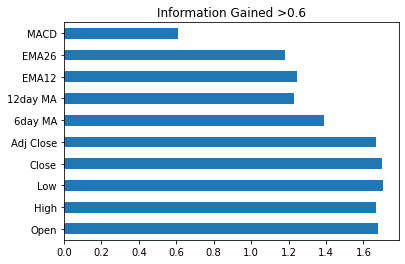

In [23]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.title('Information Gained >0.6')
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_2176/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


Open          High           Low         Close  \
Date                                                                 
2021-12-23  23193.599609  23193.599609  23193.599609  23193.599609   
2021-12-27  23223.800781  23223.800781  23223.800781  23223.800781   
2021-12-28  23280.599609  23280.599609  23280.599609  23280.599609   
2021-12-29  23086.500000  23086.500000  23086.500000  23086.500000   
2021-12-30  23112.000000  23112.000000  23112.000000  23112.000000   

               Adj Close       6day MA      12day MA         EMA12  \
Date                                                                 
2021-12-23  23193.599609  23113.366862  23494.916829  23397.249467   
2021-12-27  23223.800781  23071.416992  23430.491862  23370.565054   
2021-12-28  23280.599609  23086.083659  23349.300130  23356.724216   
2021-12-29  23086.500000  23143.016927  23273.533529  23315.151260   
2021-12-30  23112.000000  23166.466797  23203.316895  23283.897220   

                   EMA26        MACD    Prediction  
Date                                                
2021-12-23  23841.259170 -444.009703  23223.800781  
2021-12-27  23795.521511 -424.956457  23280.599609  
2021-12-28  23757.379148 -400.654932  23086.500000  
2021-12-29  23707.684396 -392.533137  23112.000000  
2021-12-30  23663.559626 -379.662406  23397.699219

In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(619, 1, 10) (619,) (69, 1, 10) (69,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_2176/2884921294.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 15:37:44.500364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 15:37:44.500483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=700,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/700


2022-04-10 15:37:44.964948: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 15:37:46.507222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:46.797585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:47.247311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:47.929695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:48.295412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 540478592.0000

2022-04-10 15:37:50.143080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:50.222986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:37:50.245053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 6s 63ms/step - loss: 540478592.0000 - val_loss: 560332928.0000
Epoch 2/700
35/35 [==============================] - 0s 14ms/step - loss: 539250624.0000 - val_loss: 557803648.0000
Epoch 3/700
35/35 [==============================] - 0s 13ms/step - loss: 536255168.0000 - val_loss: 554403392.0000
Epoch 4/700
35/35 [==============================] - 0s 12ms/step - loss: 532861920.0000 - val_loss: 550532800.0000
Epoch 5/700
35/35 [==============================] - 1s 19ms/step - loss: 528900640.0000 - val_loss: 545999232.0000
Epoch 6/700
35/35 [==============================] - 1s 17ms/step - loss: 524285952.0000 - val_loss: 540773184.0000
Epoch 7/700
35/35 [==============================] - 1s 24ms/step - loss: 519005312.0000 - val_loss: 534849792.0000
Epoch 8/700
35/35 [==============================] - 1s 16ms/step - loss: 513061696.0000 - val_loss: 528235744.0000
Epoch 9/700
35/35 [==============================] - 0s 12ms/step - loss: 506466752.

35/35 [==============================] - 0s 11ms/step - loss: 68947.7031 - val_loss: 60065.9414
Epoch 145/700
35/35 [==============================] - 0s 12ms/step - loss: 65597.9375 - val_loss: 57451.7227
Epoch 146/700
35/35 [==============================] - 0s 14ms/step - loss: 62452.4258 - val_loss: 55013.1914
Epoch 147/700
35/35 [==============================] - 0s 14ms/step - loss: 59500.9961 - val_loss: 52732.9336
Epoch 148/700
35/35 [==============================] - 0s 13ms/step - loss: 56730.5273 - val_loss: 50591.7656
Epoch 149/700
35/35 [==============================] - 1s 15ms/step - loss: 54126.9922 - val_loss: 48571.2070
Epoch 150/700
35/35 [==============================] - 0s 11ms/step - loss: 51677.7539 - val_loss: 46655.6133
Epoch 151/700
35/35 [==============================] - 0s 11ms/step - loss: 49370.5469 - val_loss: 44832.3672
Epoch 152/700
35/35 [==============================] - 0s 12ms/step - loss: 47194.7031 - val_loss: 43091.6250
Epoch 153/700
35/35 [===

35/35 [==============================] - 0s 11ms/step - loss: 5294.9019 - val_loss: 2573.7969
Epoch 220/700
35/35 [==============================] - 0s 11ms/step - loss: 5162.5815 - val_loss: 2443.3010
Epoch 221/700
35/35 [==============================] - 1s 16ms/step - loss: 5035.2808 - val_loss: 2320.6770
Epoch 222/700
35/35 [==============================] - 0s 13ms/step - loss: 4912.6685 - val_loss: 2205.7490
Epoch 223/700
35/35 [==============================] - 1s 15ms/step - loss: 4794.6987 - val_loss: 2098.1548
Epoch 224/700
35/35 [==============================] - 0s 12ms/step - loss: 4681.2246 - val_loss: 1997.5621
Epoch 225/700
35/35 [==============================] - 0s 12ms/step - loss: 4572.1050 - val_loss: 1903.2650
Epoch 226/700
35/35 [==============================] - 0s 12ms/step - loss: 4466.9961 - val_loss: 1814.4325
Epoch 227/700
35/35 [==============================] - 0s 11ms/step - loss: 4365.5874 - val_loss: 1730.1196
Epoch 228/700
35/35 [=====================

35/35 [==============================] - 0s 10ms/step - loss: 359.4732 - val_loss: 502.6805
Epoch 373/700
35/35 [==============================] - 0s 9ms/step - loss: 348.1377 - val_loss: 490.2788
Epoch 374/700
35/35 [==============================] - 0s 9ms/step - loss: 334.0620 - val_loss: 476.8590
Epoch 375/700
35/35 [==============================] - 0s 9ms/step - loss: 316.8760 - val_loss: 462.5126
Epoch 376/700
35/35 [==============================] - 0s 9ms/step - loss: 296.6870 - val_loss: 447.7311
Epoch 377/700
35/35 [==============================] - 0s 9ms/step - loss: 274.8921 - val_loss: 433.3562
Epoch 378/700
35/35 [==============================] - 0s 9ms/step - loss: 254.4426 - val_loss: 420.7057
Epoch 379/700
35/35 [==============================] - 0s 9ms/step - loss: 239.4487 - val_loss: 411.4400
Epoch 380/700
35/35 [==============================] - 0s 10ms/step - loss: 232.2140 - val_loss: 406.4277
Epoch 381/700
35/35 [==============================] - 0s 10ms/step

Epoch 527/700
35/35 [==============================] - 0s 10ms/step - loss: 62.1683 - val_loss: 79.5396
Epoch 528/700
35/35 [==============================] - 0s 11ms/step - loss: 120.1088 - val_loss: 86.8655
Epoch 529/700
35/35 [==============================] - 0s 10ms/step - loss: 141.6703 - val_loss: 50.7488
Epoch 530/700
35/35 [==============================] - 0s 10ms/step - loss: 93.4232 - val_loss: 60.1980
Epoch 531/700
35/35 [==============================] - 0s 11ms/step - loss: 69.8495 - val_loss: 82.8293
Epoch 532/700
35/35 [==============================] - 0s 10ms/step - loss: 126.3294 - val_loss: 118.6469
Epoch 533/700
35/35 [==============================] - 0s 10ms/step - loss: 189.4533 - val_loss: 75.7463
Epoch 534/700
35/35 [==============================] - 0s 9ms/step - loss: 96.1920 - val_loss: 69.0907
Epoch 535/700
35/35 [==============================] - 0s 9ms/step - loss: 151.4980 - val_loss: 59.4270
Epoch 536/700
35/35 [==============================] - 0s 10

35/35 [==============================] - 0s 11ms/step - loss: 105.6871 - val_loss: 54.7771
Epoch 606/700
35/35 [==============================] - 0s 10ms/step - loss: 87.4688 - val_loss: 56.2677
Epoch 607/700
35/35 [==============================] - 0s 10ms/step - loss: 51.7478 - val_loss: 81.3079
Epoch 608/700
35/35 [==============================] - 0s 10ms/step - loss: 117.7307 - val_loss: 104.2522
Epoch 609/700
35/35 [==============================] - 0s 10ms/step - loss: 162.9003 - val_loss: 72.0796
Epoch 610/700
35/35 [==============================] - 0s 9ms/step - loss: 84.3139 - val_loss: 49.2905
Epoch 611/700
35/35 [==============================] - 0s 10ms/step - loss: 97.3649 - val_loss: 31.4412
Epoch 612/700
35/35 [==============================] - 0s 10ms/step - loss: 125.5314 - val_loss: 242.6884
Epoch 613/700
35/35 [==============================] - 0s 9ms/step - loss: 377.9358 - val_loss: 98.3540
Epoch 614/700
35/35 [==============================] - 0s 10ms/step - los

2022-04-10 15:42:17.468586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:42:17.538086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:42:17.582420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


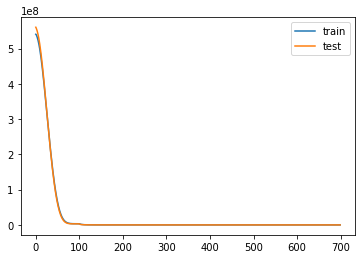

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

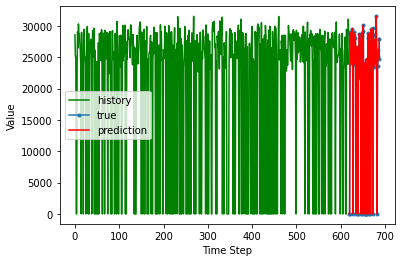

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

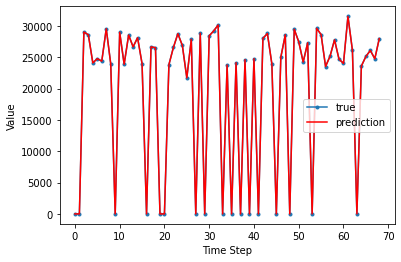

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.9999996209425792

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

1.7077591801772205

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

7.1391091353742215

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_2176/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


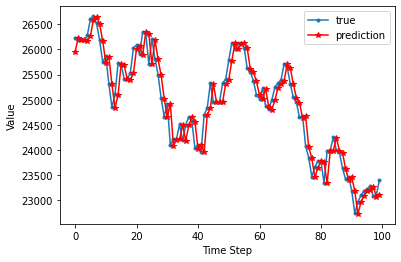

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.9132754060695902

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009482541655167525

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

298.6094302355498